In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
import os
from pathlib import Path
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

# Evaluation on Test and Inference Sets

We'll start by evaluating the provided model on the test and inference sets. This will help us understand if there is a gap in performance between the two sets, which could indicate issues with data leakage on the test set or data drift in the inference set.

### Get inference set features and labels


In [3]:
# creates data/inference.csv
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|██████████| 473/473 [00:01<00:00, 320.07it/s]

Processed 473 samples to data/inference.csv


x_mean     x_std      x_max     x_min    x_range    x_skew  x_kurtosis  \
0    2.578586  2.362892   8.999561 -5.200753  14.200314  0.193760    1.400440   
1   -0.114423  2.185548  10.289834 -5.283784  15.573618  2.164783    7.702143   
2    0.061702  0.147340   0.291371 -0.208436   0.499806 -0.407912   -1.211002   
3    1.354891  2.486652  11.114359 -6.365416  17.479775  0.764660    3.152818   
4    0.061687  0.141320   0.278571 -0.246872   0.525443 -0.440889   -1.157643   
..        ...       ...        ...       ...        ...       ...         ...   
468  0.060402  0.141580   0.300225 -0.230982   0.531207 -0.394775   -1.216041   
469  0.159769  2.509925   8.347333 -9.574540  17.921873  0.287556    3.356591   
470 -0.548699  2.591718   6.550702 -8.426525  14.977227 -0.191147    1.450593   
471 -0.559437  1.851954   4.829766 -6.744202  11.573968 -0.103196    1.832355   
472  1.097805  1.782988   6.098609 -6.824390  12.922999 -0.822844    3.602370   

     x_n_peaks     x_energy    y_mean  ...  temperature  humidity  altitude  \
0           31  1223.236383  2.995496  ...           12        49       996   
1            5   478.971240  0.343485  ...           22        75       607   
2           15     2.551629  0.015451  ...           30        52       482   
3           15   801.916607  1.424555  ...           11        36       463   
4           17     2.377675  0.018567  ...           13        41       759   
..         ...          ...       ...  ...          ...       ...       ...   
468         14     2.369336  0.015395  ...           15        57       750   
469         10   632.524802  1.805974  ...           12        76       900   
470         11   701.807315  1.414847  ...           22        77        11   
471          9   374.270158  1.994104  ...           29        50       831   
472         22   438.422408 -1.092403  ...           27        57       602   

     session_id  firmware_version  calibration_status  battery_level  \
0       S603575            v1.3.0                  ok             79   
1       S949312            v1.2.4                  ok             81   
2       S223545            v1.2.3              recent             95   
3       S993755            v1.2.3             pending             47   
4       S734746            v1.2.4              recent             37   
..          ...               ...                 ...            ...   
468     S165342            v1.2.4                  ok             54   
469     S653588            v1.3.0             pending             23   
470     S945979            v1.3.0             pending             80   
471     S424057            v1.3.0             pending             83   
472     S493380            v1.2.3              recent             22   

     gps_accuracy  network_type  device_model  
0        5.570705            4g       model_c  
1        3.181146            4g       model_c  
2        2.987759            4g       model_b  
3        9.744692            4g       model_a  
4        3.622219          wifi       model_a  
..            ...           ...           ...  
468      9.761510            4g       model_c  
469      8.203065            4g       model_a  
470      5.033353            5g       model_b  
471      1.703700            5g       model_c  
472      7.659065            4g       model_a  

[473 rows x 60 columns]

In [4]:
# load the inference labels
inf_labels_df = pd.read_csv("data/manual_annotation/inference_labels.csv")

### Check the label distribution in the three sets

In [5]:
# Inspect training label distribution
train_df = pd.read_csv("data/train.csv")
train_labels = train_df['label']

print(f"Unique Train Labels: {train_labels.unique()}")
print("Label Counts:\n", train_labels.value_counts())

Unique Train Labels: ['normal' 'collision']
Label Counts:
 label
normal       400
collision    400
Name: count, dtype: int64


In [6]:
# Inspect test label distribution
test_df = pd.read_csv("data/test.csv")
test_labels = test_df['label']

print(f"Unique Test Labels: {test_labels.unique()}")
print("Label Counts:\n", test_labels.value_counts())

Unique Test Labels: ['normal' 'collision']
Label Counts:
 label
normal       100
collision    100
Name: count, dtype: int64


In [7]:
# Inspect inference label distribution
inference_labels = inf_labels_df["label"]

print(f"Unique Inference Labels: {inference_labels.unique()}")
print("Label Counts:\n", inference_labels.value_counts())

Unique Inference Labels: ['collision' 'normal']
Label Counts:
 label
normal       237
collision    236
Name: count, dtype: int64


We can see that the label distribution is similar across the training, test, and inference sets, and **all three sets are balanced**. This is a good sign as it indicates that the model is not biased towards any particular class and should perform well across all classes. Moreover, since we have no class imbalance, the **accuracy** will be a reliable metric for evaluating the model's performance.

### Get predictions and compute metrics for the test and inference sets

```python

In [8]:
# Load the trained model
model = joblib.load("models/imu_pipeline.pkl")

In [9]:
# Keep sample IDs for later
test_sample_ids = test_df["sample_id"]

X_test = test_df.drop(columns=["sample_id", "label"])  # features only
y_test = test_df["label"]

preds_test = model.predict(X_test)

# Combine sample_id, true labels, and predictions for tracking
results_test_df = pd.DataFrame(
    {"sample_id": test_sample_ids, "true_label": y_test, "predicted_label": preds_test}
)

In [10]:
print("\nClassification Report (Test Set):")
print(classification_report(y_test, preds_test))

cm_test = confusion_matrix(y_test, preds_test)
print("\nConfusion Matrix (Test Set):")
print(pd.DataFrame(cm_test, index=np.unique(y_test), columns=np.unique(y_test)))


Classification Report (Test Set):
              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200


Confusion Matrix (Test Set):
           collision  normal
collision         89      11
normal             0     100


In [11]:
# Load the inference set features
inf_features_df = pd.read_csv("data/inference.csv")

# Compute the predictions for the inference set
inf_preds = model.predict(inf_features_df)

# Merge predictions and features
inf_preds_df = pd.DataFrame({
    'sample_id': inf_features_df['sample_id'],
    'predicted_label': inf_preds
})

# Join predictions with manual labels
inf_merged_df = inf_labels_df.merge(inf_preds_df, on='sample_id', how='inner')

# Add all input features (e.g., sensor_source) to merged DataFrame
inf_merged_df = inf_merged_df.merge(inf_features_df, on='sample_id', how='left')

# Extract aligned y_true and y_pred
y_true_inf = inf_merged_df['label']
y_pred_inf = inf_merged_df['predicted_label']

In [12]:
# Inference Evaluation Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("Classification Report (Inference Set):")
print(classification_report(y_true_inf, y_pred_inf))

cm_inf = confusion_matrix(y_true_inf, y_pred_inf)
print("Confusion Matrix (Inference Set):")
print(pd.DataFrame(cm_inf, index=np.unique(y_true_inf), columns=np.unique(y_true_inf)))

Classification Report (Inference Set):
              precision    recall  f1-score   support

   collision       0.59      0.96      0.73       236
      normal       0.89      0.33      0.48       237

    accuracy                           0.64       473
   macro avg       0.74      0.65      0.61       473
weighted avg       0.74      0.64      0.61       473

Confusion Matrix (Inference Set):
           collision  normal
collision        226      10
normal           158      79


### Conclusion

The metrics indicate that while the model performs well on the test set (94% accuracy), there is a noticeable drop in performance on the inference set (64% accuracy). Interestingly, in the inference set, the model often misclassifies normal examples as collisions, which never happens in the test set. 

This performance drop suggests that one of the following issues might be present:
1. **Data Leakage**: The test set might contain examples that are identical or too similar to the training set.
2. **Data Drift**: The distribution of the inference data might differ from the training and test data, causing the model to perform poorly on unseen examples.

# 📊 Exploratory Data Analysis

Let's investigate possible reasons for the performance gap between the inference and test sets. We'll first investigate whether there is evidence of data leakage. Then, we'll analyze the inference set to see if there significant differences in feature distributions that could explain the performance drop.

### Data leakage investigation (test set vs. training set)

We'll do some sanity checks on the test set to ensure that there is no data leakage from the training set, by looking for duplicate samples and overlapping feature rows.

In [13]:
for col in ['sample_id', 'session_id', 'driver_id']:
    # Check for overlaps between train and test sets
    ids_train = set(train_df[col])
    ids_test = set(test_df[col])
    overlap_ids = ids_train.intersection(ids_test)
    print(f"Number of unique {col}s in train set: {len(ids_train)}")
    print(f"Number of unique {col}s in test set: {len(ids_test)}")
    print(f"Number of overlapping {col}s between train and test: {len(overlap_ids)}")
    if overlap_ids:
        print(f"Overlapping {col}s:", list(overlap_ids)[:10])  # Show up to 10
    print("-" * 40)

# Check for duplicate feature rows (excluding sample_id, label, and metadata columns)
feature_cols = [col for col in train_df.columns if col not in {'sample_id', 'label', 'timestamp', 'sensor_source', 'weather', 'driver_id', 'vehicle_type', 'speed_bin', 'road_type', 'time_of_day', 'session_id', 'firmware_version', 'calibration_status', 'battery_level', 'gps_accuracy', 'network_type', 'device_model', 'temperature', 'humidity', 'altitude'}]

# Merge on all feature columns to find identical feature rows
merged = pd.merge(
    train_df[feature_cols + ['sample_id']],
    test_df[feature_cols + ['sample_id']],
    on=feature_cols,
    how='inner',
    suffixes=('_train', '_test')
)
print(f"Number of test samples with identical feature rows in training set: {len(merged)}")
if not merged.empty:
    print("Example of overlapping feature rows (showing up to 5):")
    display(merged.head())

Number of unique sample_ids in train set: 800
Number of unique sample_ids in test set: 200
Number of overlapping sample_ids between train and test: 0
----------------------------------------
Number of unique session_ids in train set: 800
Number of unique session_ids in test set: 200
Number of overlapping session_ids between train and test: 1
Overlapping session_ids: ['S874145']
----------------------------------------
Number of unique driver_ids in train set: 100
Number of unique driver_ids in test set: 90
Number of overlapping driver_ids between train and test: 90
Overlapping driver_ids: ['D1018', 'D1035', 'D1012', 'D1030', 'D1056', 'D1070', 'D1043', 'D1000', 'D1083', 'D1013']
----------------------------------------
Number of test samples with identical feature rows in training set: 0


We can see that there are no exact duplicates between the training and test sets, which is a good sign. The only overlap is in the driver ids: all the drivers in the test set are also present in the training set. This should not be a big issue, as the model is trained on a diverse set of drivers, but we'll keep this in mind when analyzing the inference set.

**Conclusion**: There is no evidence of significant data leakage from the training set to the test set.

### Data drift investigation (test set vs. inference set)

We'll now check for data drift between the test set and the inference set. Since we've already checked the label distributions (both are balanced), we'll look for differences in the distribution of the input (categorical and numeric) features between the two sets.

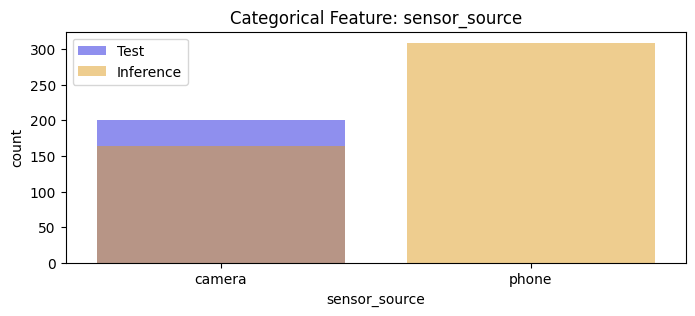

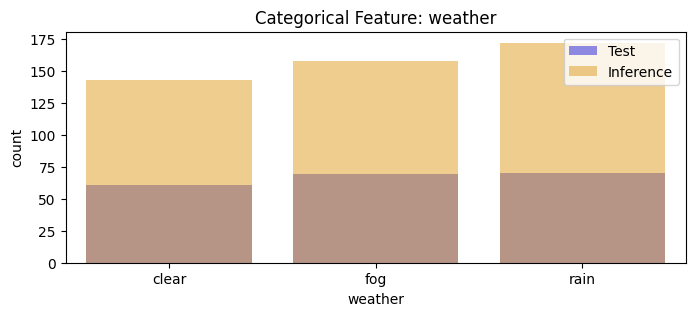

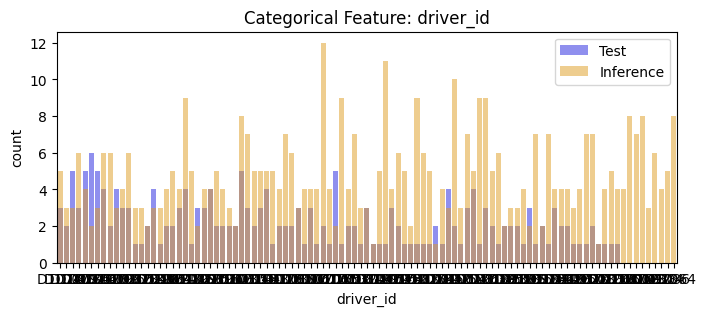

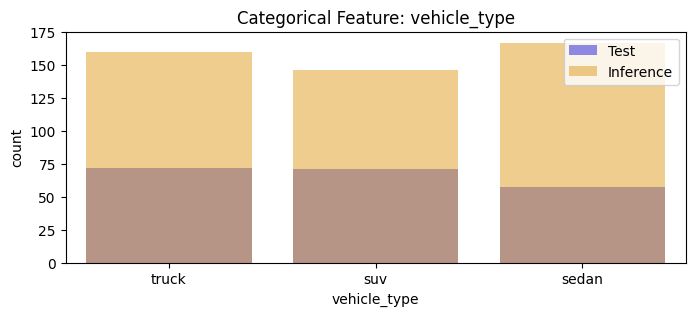

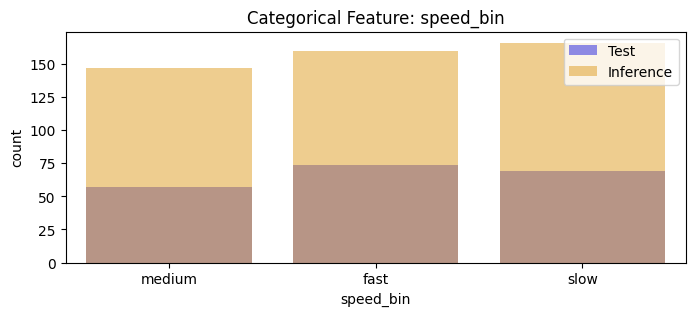

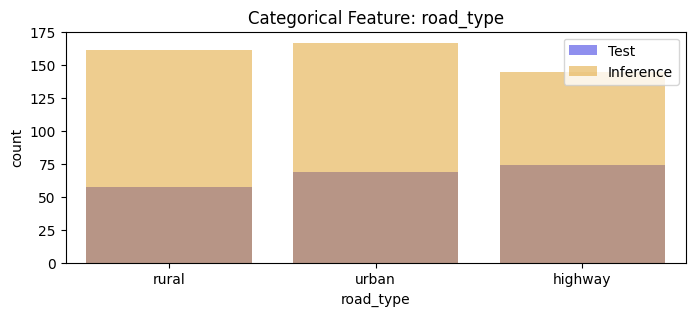

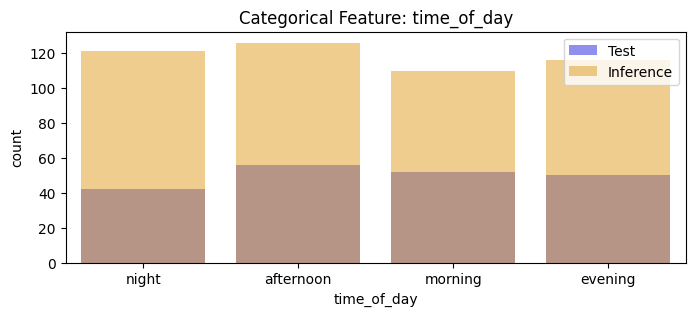

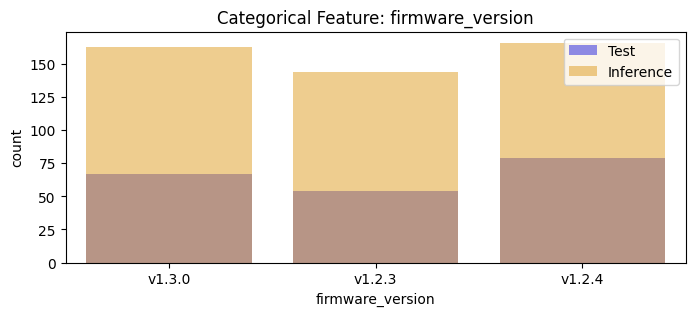

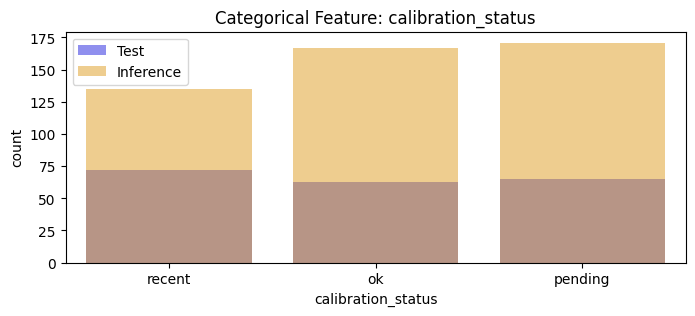

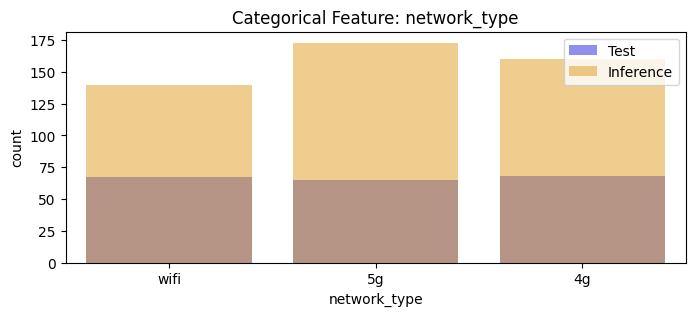

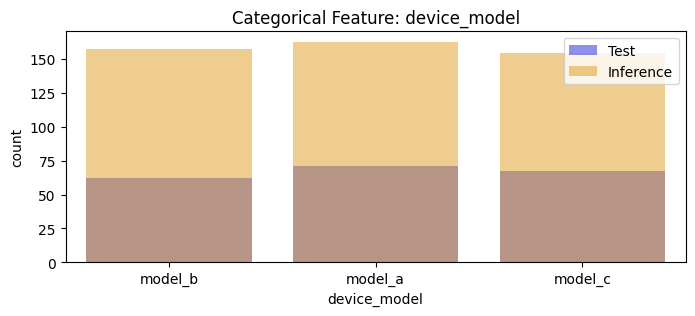

In [14]:
# Compare categorical features (if any) between test and inference sets
cat_cols = [
    col
    for col in inf_features_df.columns
    if inf_features_df[col].dtype == "object"
    and col not in {"sample_id", "session_id", "timestamp"}
]
if cat_cols:
    for col in cat_cols:
        fig, ax = plt.subplots(1, 1, figsize=(8, 3))
        sns.countplot(x=col, data=test_df, color="blue", alpha=0.5, label="Test")
        sns.countplot(
            x=col, data=inf_features_df, color="orange", alpha=0.5, label="Inference"
        )
        ax.set_title(f"Categorical Feature: {col}")
        ax.legend()
        plt.show()
else:
    print("No categorical features found.")

There are two main findings from this analysis:
- **Major finding**: The inference set contains samples coming from the `phone` sensor, whereas the test set only contains samples from the `camera` sensor. This might be a significant factor contributing to the performance drop, especially if the training set also contains samples from the `camera` sensor only.
- **Minor finding**: The inference set contains samples from a few drivers that are not present in the test set, which might also contribute to the performance drop if those drivers have different driving styles and are also not present in the training set.

To investigate this further, let's compare the `driver_id` and `sensor` distributions between the test and training sets.

In [15]:
# Check for overlap in driver_id between inference and training sets
train_driver_ids = set(train_df['driver_id'])
inf_driver_ids = set(inf_merged_df["driver_id"])
overlap_driver_ids = train_driver_ids.intersection(inf_driver_ids)
print(f"Number of unique driver_ids in train set: {len(train_driver_ids)}")
print(f"Number of unique driver_ids in inference set: {len(inf_driver_ids)}")
print(f"Number of overlapping driver_ids: {len(overlap_driver_ids)}")

Number of unique driver_ids in train set: 100
Number of unique driver_ids in inference set: 99
Number of overlapping driver_ids: 99


All the drivers in the inference set are also present in the training set, so this is not a significant factor contributing to the performance drop. We'll now check the distribution of the `sensor` feature in the training set.

In [16]:
# Check the sensor distribution in the training set
sensor_counts_train = train_df['sensor_source'].value_counts()
print("Sensor Distribution in Training Set:")
print(sensor_counts_train)

Sensor Distribution in Training Set:
sensor_source
camera    800
Name: count, dtype: int64


As we can see, the training set also does not contain samples from the `phone` sensor, which is most likely the main reason for the performance drop on the inference set. The model is not trained on samples from the `phone` sensor, so it probably does not generalize well to those samples.

Before confirming this hypothesis, let's check the distribution of the numeric features in the training and inference sets to see if there are any significant differences that could also contribute to the performance drop.

In [17]:
# Check for feature drift using summary statistics
numeric_cols = [
    col
    for col in inf_features_df.columns
    if inf_features_df[col].dtype in ["float64", "int64"]
]
drift_stats = pd.DataFrame(
    {
        "test_mean": test_df[numeric_cols].mean(),
        "inf_mean": inf_features_df[numeric_cols].mean(),
        "test_std": test_df[numeric_cols].std(),
        "inf_std": inf_features_df[numeric_cols].std(),
    }
)
drift_stats["mean_diff"] = (drift_stats["inf_mean"] - drift_stats["test_mean"]).abs()
drift_stats_sorted = drift_stats.sort_values("mean_diff", ascending=False)
print("Top features with largest mean difference between test and inference:")
display(drift_stats_sorted.head(10))

Top features with largest mean difference between test and inference:


test_mean      inf_mean    test_std      inf_std   mean_diff
z_energy    9683.292067  10275.442216   16.979790  2143.586208  592.150150
x_energy       3.955851    403.629173    2.676421   352.366176  399.673322
y_energy       2.659258    287.908905    0.749854   291.278571  285.249647
y_fft_max      8.794528     77.185222    0.755214    78.335992   68.390693
x_fft_max      9.368770     68.027978    1.329026    65.119580   58.659208
z_fft_max    984.017783   1005.767172    0.883487   103.778212   21.749390
altitude     510.165000    495.238901  275.843208   280.088576   14.926099
x_fft_mean     1.092364     13.967131    0.672068     9.928472   12.874767
y_fft_mean     0.881604     10.787327    0.308721     7.564381    9.905722
x_range        0.884504      9.869767    0.661643     7.180939    8.985264

This summary shows that there are significant differences in the distributions of the numeric features between the test and inference sets. Maybe, these are also caused by the fact that the inference set contains samples from the `phone` sensor, which is not present in the training set. 

Let's investigate this hypothesis by plotting the distributions of the numeric features in the test set, on the inference set with `camera` sensor and on the inference set with `phone` sensor.

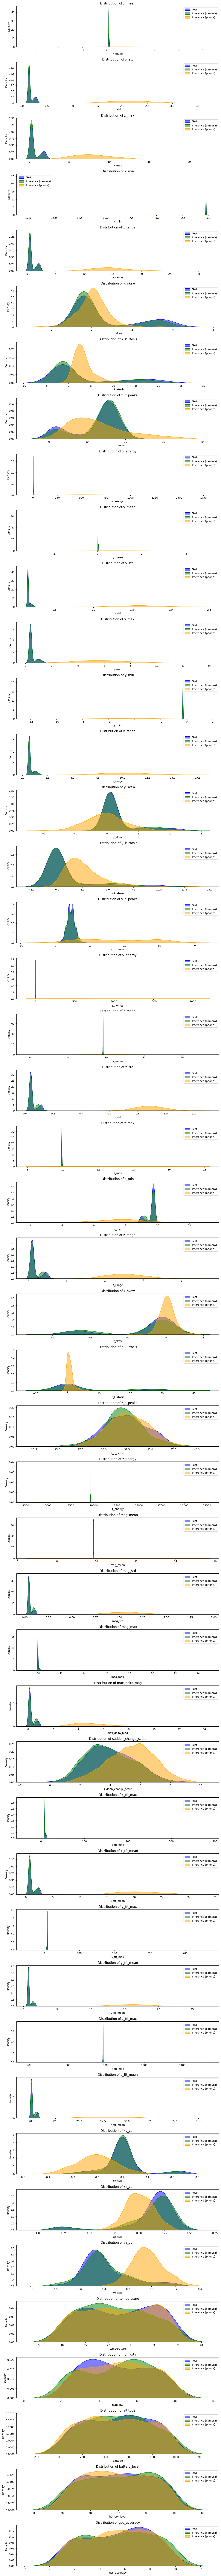

In [18]:
inf_camera = inf_features_df[inf_features_df["sensor_source"] == "camera"]
inf_phone = inf_features_df[inf_features_df["sensor_source"] == "phone"]

n_show = len(numeric_cols)
fig, axes = plt.subplots(n_show, 1, figsize=(12, 3 * n_show))
for i, col in enumerate(numeric_cols[:n_show]):
    sns.kdeplot(test_df[col], label='Test', ax=axes[i], fill=True, color='blue', alpha=0.5)
    if not inf_camera.empty:
        sns.kdeplot(inf_camera[col], label='Inference (camera)', ax=axes[i], fill=True, color='green', alpha=0.5)
    if not inf_phone.empty:
        sns.kdeplot(inf_phone[col], label='Inference (phone)', ax=axes[i], fill=True, color='orange', alpha=0.5)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()
plt.tight_layout()
plt.show()

As we suspected, the distributions of the numeric features in the inference set with `phone` sensor are significantly different from those in the test set and the inference set with `camera` sensor. This is an even stronger indication that the performance drop is mainly caused by the fact that the inference set contains samples from the `phone` sensor, which is not present in the training set.

We'll now confirm this hypothesis by evaluating the model on the inference set with `camera` sensor only and on the inference set with `phone` sensor only.

In [19]:
# Compute the classification report for inference set for camera and phone images separately
camera_inf = inf_merged_df[inf_merged_df["sensor_source"] == "camera"]
phone_inf = inf_merged_df[inf_merged_df["sensor_source"] == "phone"]

camera_report = classification_report(
    camera_inf["label"], camera_inf["predicted_label"]
)
phone_report = classification_report(
    phone_inf["label"], phone_inf["predicted_label"]
)
print("Camera Sensor Classification Report (Inference Set):")
print(camera_report)
print("\nPhone Sensor Classification Report (Inference Set):")
print(phone_report)

Camera Sensor Classification Report (Inference Set):
              precision    recall  f1-score   support

   collision       1.00      0.88      0.94        85
      normal       0.89      1.00      0.94        79

    accuracy                           0.94       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.95      0.94      0.94       164


Phone Sensor Classification Report (Inference Set):
              precision    recall  f1-score   support

   collision       0.49      1.00      0.66       151
      normal       0.00      0.00      0.00       158

    accuracy                           0.49       309
   macro avg       0.24      0.50      0.33       309
weighted avg       0.24      0.49      0.32       309



Exactly as we suspected, the model performs well on the inference set with `camera` sensor (94% accuracy), but performs even worse than random on the inference set with `phone` sensor (49% accuracy)!

**Conclusion**: The root cause of the performance drop on the inference set is the fact that the inference set contains samples from the `phone` sensor, which is not present in the training set. As we have seen before, the `phone` senor yields significantly different distributions of the numeric features compared to the training set. This leads to a drop in performance on the inference set, as the model is not able to generalize well to those samples.

# ✨ Data Drift Mitigation

To mitigate the data drift issue, we can either:
1. **Use domain adaptation techniques** to adapt the model to the new distribution of the `phone` sensor. This can be done by fine-tuning the model on a small set of labeled samples from the `phone` sensor, by training a new model on the task of converting the `phone` sensor data to the `camera` sensor data, or by using techniques such as adversarial training to make a model more robust to domain shifts.
2. **Retrain the model** on a dataset that contains samples from the `phone` sensor, so that the model can learn to generalize to those samples, or training a separate model specialized on this type of sensor data. Both of these solutions are more straightforward and preferable over doing domain adaptation, but it requires access to a dataset that contains samples from the `phone` sensor.

### Domain Adaptation

Applying a thorough domain adaptation technique to adapt the model to the new distribution is outside the scope of this notebook. However, since we have observed that the scalings of the numeric features are very different for the `phone` sensor compared to the `camera` sensor, we can try a simple approach to mitigate the data drift issue by scaling the numeric features in the inference set with `phone` sensor to match the distribution of the numeric features in the training set. 

In [20]:
# Compute mean and std for each numeric feature in train and phone_inf
train_means = train_df[numeric_cols].mean()
train_stds = train_df[numeric_cols].std()
phone_means = phone_inf[numeric_cols].mean()
phone_stds = phone_inf[numeric_cols].std()

# Scale phone sensor features to match train distribution
scaled_phone_inf = phone_inf.copy()
for col in numeric_cols:
    # Avoid division by zero
    if phone_stds[col] > 0:
        scaled_phone_inf[col] = ((phone_inf[col] - phone_means[col]) / phone_stds[col]) * train_stds[col] + train_means[col]
    else:
        scaled_phone_inf[col] = train_means[col]

# Get the model predictions for the scaled phone sensor features
scaled_phone_preds = model.predict(scaled_phone_inf[numeric_cols])

# Compute the classification report for scaled phone sensor features
scaled_phone_inf["predicted_label"] = scaled_phone_preds
scaled_phone_report = classification_report(
    scaled_phone_inf["label"], scaled_phone_inf["predicted_label"]
)
print("Scaled Phone Sensor Classification Report (Inference Set):")
print(scaled_phone_report)


Scaled Phone Sensor Classification Report (Inference Set):
              precision    recall  f1-score   support

   collision       0.49      0.99      0.65       151
      normal       0.00      0.00      0.00       158

    accuracy                           0.48       309
   macro avg       0.24      0.49      0.33       309
weighted avg       0.24      0.48      0.32       309



Unfortunately, this very simple approach did not work well, as the model accuracy even worsened a little bit. We may need to explore more advanced domain adaptation methods to improve performance on the phone sensor data, but implementing such methods is outside the scope of this notebook.

## Training a separate model for the phone sensor

By inspecting the functions defined in `extract_features.py`, we realized that the provided raw data contains samples from the `phone` sensor for all the splits (however, when `camera` data is present, it is always preferred). This means that we can train a separate model for the `phone` sensor, which we will do next.

In [21]:
# Save a copy of the training and test data without the camera sensor data
for split in ['train', 'test']:
    os.makedirs(f"data/raw/{split}_phone", exist_ok=True)
    for f in os.listdir(f"data/raw/{split}"):
        if f.endswith(".npz"):
            with np.load(f"data/raw/{split}/{f}") as data:
                # Filter out camera sensor data
                data = {k: v for k, v in data.items() if k != "camera_signal"}
                # Save the phone data to a new file
                np.savez(f"data/raw/{split}_phone/{f}", **data)


In [22]:
# Prepare the features for the phone training and test data
process_dataset("train_phone")
process_dataset("test_phone")

[INFO] No label CSV found for 'train_phone' – proceeding without labels.

Processing 'train_phone' dataset...


100%|██████████| 800/800 [00:02<00:00, 364.96it/s]


Processed 800 samples to data/train_phone.csv
[INFO] No label CSV found for 'test_phone' – proceeding without labels.

Processing 'test_phone' dataset...


100%|██████████| 200/200 [00:00<00:00, 368.97it/s]

Processed 200 samples to data/test_phone.csv


x_mean     x_std      x_max      x_min    x_range    x_skew  \
0    0.688598  2.355797   8.173880  -6.796526  14.970406  0.157844   
1   -1.009274  3.032485   7.105936 -11.546126  18.652062 -0.534566   
2    0.315298  1.912851  11.120453  -2.909553  14.030006  2.456206   
3    1.946337  2.271768   6.800975  -9.366298  16.167273 -1.759068   
4    1.333204  1.632731   9.031842  -1.638451  10.670293  1.800495   
..        ...       ...        ...        ...        ...       ...   
195 -1.048028  1.534549   3.449841  -6.247775   9.697616 -0.203771   
196  0.651977  1.837868   6.721758  -3.970175  10.691933  0.376271   
197 -1.481319  2.802233   5.346264 -16.590324  21.936588 -1.839456   
198 -0.062065  2.127704   8.922904  -8.472868  17.395771  1.028035   
199  1.051239  2.658031  12.205760  -8.433398  20.639159  0.389679   

     x_kurtosis  x_n_peaks     x_energy    y_mean  ...  temperature  humidity  \
0      1.853376         13   602.394803  0.583964  ...           29        39   
1      2.512338          6  1021.460267 -1.168342  ...           10        63   
2      9.702373          9   375.841122  0.631877  ...           31        27   
3      5.942858         26   894.915718  0.679534  ...           15        23   
4      4.631566         19   444.324366  0.036121  ...           29        75   
..          ...        ...          ...       ...  ...          ...       ...   
195    2.179177          6   345.320126 -0.824724  ...           26        37   
196    1.232794         15   380.283092 -0.658011  ...           17        76   
197    8.505071          4  1004.681379  1.054201  ...           24        69   
198    6.430200          7   453.097641 -0.086039  ...           18        28   
199    4.428803         10   817.023325 -0.283296  ...           26        47   

     altitude  session_id  firmware_version  calibration_status  \
0         746     S727700            v1.2.4             pending   
1         909     S100117            v1.2.4              recent   
2         177     S263202            v1.3.0                  ok   
3         256     S838030            v1.3.0             pending   
4          45     S596091            v1.2.4                  ok   
..        ...         ...               ...                 ...   
195       585     S244338            v1.2.3                  ok   
196       627     S782479            v1.3.0              recent   
197       888     S394241            v1.2.4                  ok   
198       450     S237515            v1.3.0             pending   
199       754     S397366            v1.3.0             pending   

     battery_level  gps_accuracy  network_type  device_model  
0               48      8.443427            4g       model_a  
1               32      2.879479            5g       model_a  
2               25      7.943552          wifi       model_b  
3               98      4.817392          wifi       model_c  
4               37      1.001352            4g       model_a  
..             ...           ...           ...           ...  
195             77      1.607092            4g       model_b  
196             26      5.538518          wifi       model_a  
197             47      2.741692            4g       model_c  
198             98      4.233080            5g       model_c  
199             84      7.545904            4g       model_a  

[200 rows x 60 columns]

In [23]:
# Load the phone training data
phone_train_df = pd.read_csv("data/train_phone.csv")
# Join the labels of train_df to phone_train_df
phone_train_df = phone_train_df.merge(train_df[['sample_id', 'label']], on='sample_id', how='left')

# Load the phone test data
phone_test_df = pd.read_csv("data/test_phone.csv")
# Join the labels of test_df to phone_test_df
phone_test_df = phone_test_df.merge(test_df[['sample_id', 'label']], on='sample_id', how='left')

# Count the number of samples in each class as a sanity check. These should be the same as before.
print("Phone Training Set Class Distribution:")
print(phone_train_df['label'].value_counts())
print("\nPhone Test Set Class Distribution:")
print(phone_test_df['label'].value_counts())
print("\nPhone Inference Set Class Distribution:")
print(phone_inf['label'].value_counts())

Phone Training Set Class Distribution:
label
collision    400
normal       400
Name: count, dtype: int64

Phone Test Set Class Distribution:
label
collision    100
normal       100
Name: count, dtype: int64

Phone Inference Set Class Distribution:
label
normal       158
collision    151
Name: count, dtype: int64


Before training the new model, let's verify if the features in the `phone` training set are similar to those in the `phone` inference set.

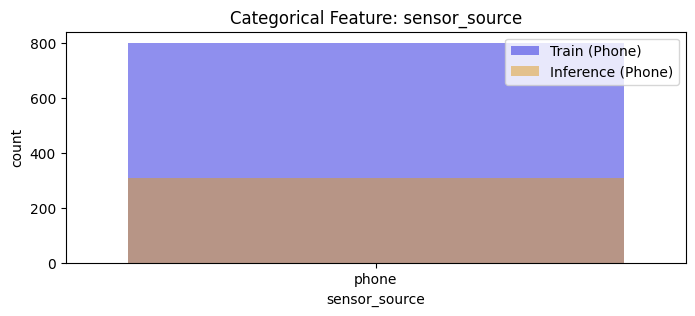

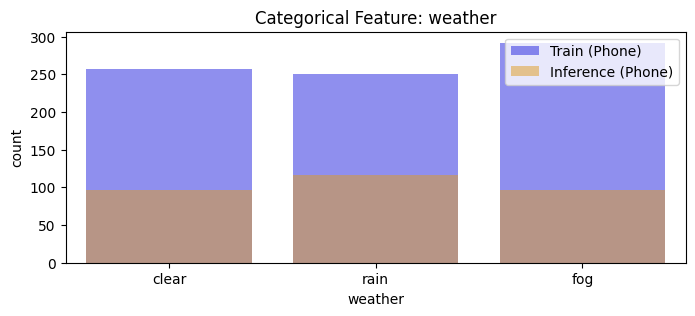

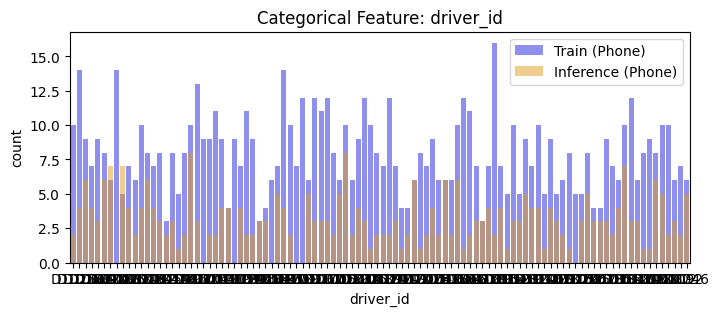

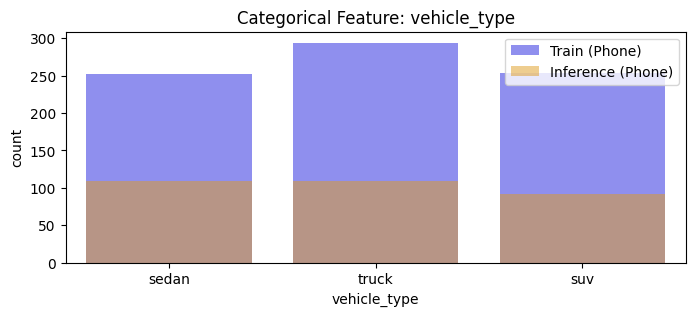

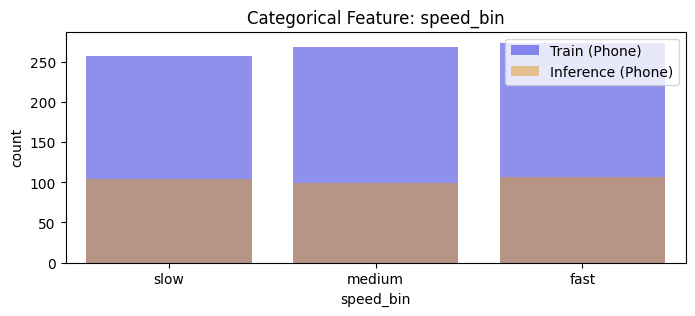

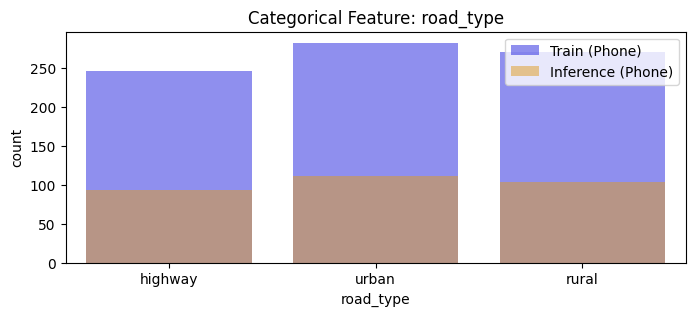

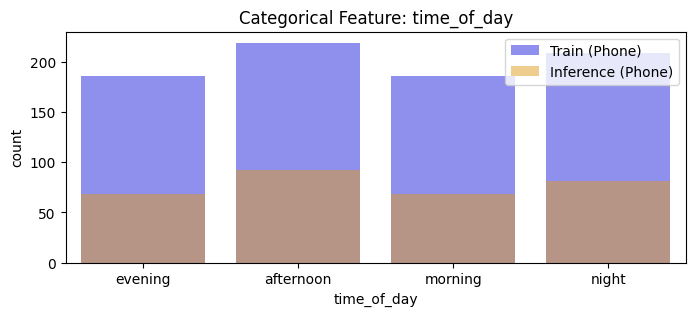

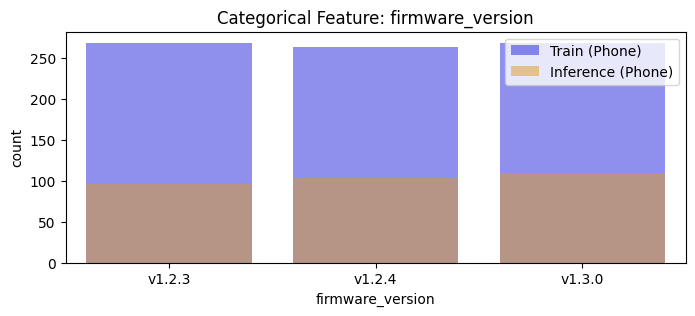

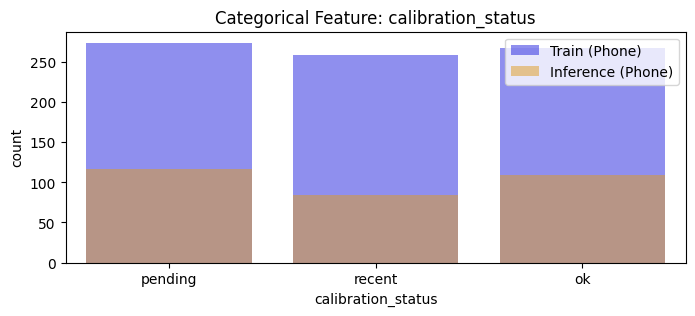

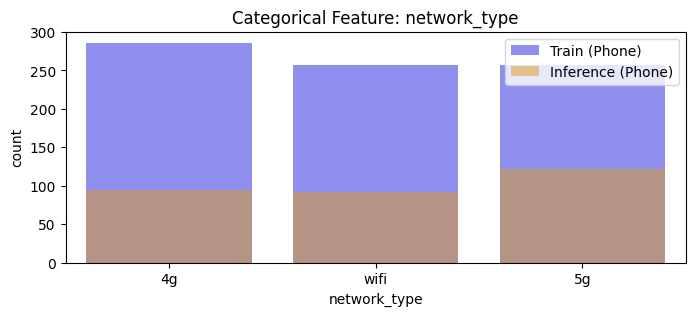

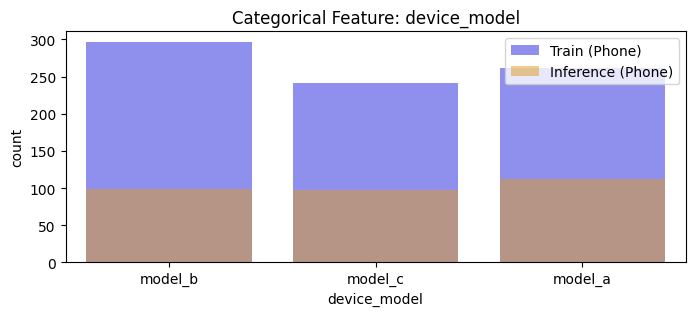

In [24]:
for col in cat_cols:
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    sns.countplot(x=col, data=phone_train_df, color="blue", alpha=0.5, label="Train (Phone)")
    sns.countplot(x=col, data=phone_inf, color="orange", alpha=0.5, label="Inference (Phone)")
    ax.set_title(f"Categorical Feature: {col}")
    ax.legend()
    plt.show()

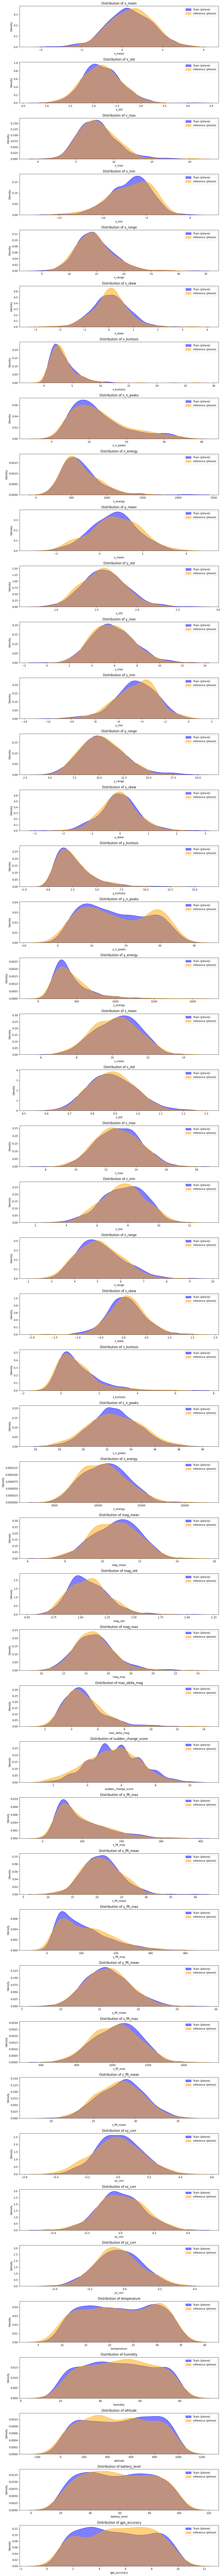

In [25]:
fig, axes = plt.subplots(n_show, 1, figsize=(12, 3 * n_show))
for i, col in enumerate(numeric_cols):
    sns.kdeplot(
        phone_train_df[col],
        label="Train (phone)",
        ax=axes[i],
        fill=True,
        color="blue",
        alpha=0.5,
    )
    sns.kdeplot(
        phone_inf[col],
        label="Inference (phone)",
        ax=axes[i],
        fill=True,
        color="orange",
        alpha=0.5,
    )
    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()
plt.tight_layout()
plt.show()

As expected, the feature distributions in the `phone` training set are similar to those in the `phone` inference set. Let's train the model.

In [26]:
# Train a new IMUPipeline for phone data
phone_pipeline = IMUPipeline()
phone_pipeline.fit(phone_train_df, phone_train_df['label'])


IMUPipeline()

In [27]:
# Evaluate the phone pipeline on the phone training data
phone_preds = phone_pipeline.predict(phone_train_df)

# Compute the classification report for phone training data
print("Classification Report (Phone Training Data):")
print(classification_report(phone_train_df['label'], phone_preds))

Classification Report (Phone Training Data):
              precision    recall  f1-score   support

   collision       1.00      1.00      1.00       400
      normal       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



The model has achieved a perfect accuracy on the training set. Let's now evaluate the model on the test and inference sets with `phone` sensor only.

In [28]:
# Evaluate the phone pipeline on the phone test data
phone_preds = phone_pipeline.predict(phone_test_df)

# Compute the classification report for phone test data
print("Classification Report (Phone Test Data):")
print(classification_report(phone_test_df["label"], phone_preds))

Classification Report (Phone Test Data):
              precision    recall  f1-score   support

   collision       0.52      0.50      0.51       100
      normal       0.51      0.53      0.52       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.52      0.51       200



In [29]:
# Evaluate the phone pipeline on the phone inference data
phone_inf_preds = phone_pipeline.predict(phone_inf.drop(columns=['sample_id']))

# Compute the classification report for phone inference data
print("Classification Report (Phone Inference Data):")
print(classification_report(phone_inf['label'], phone_inf_preds))

Classification Report (Phone Inference Data):
              precision    recall  f1-score   support

   collision       0.47      0.51      0.49       151
      normal       0.49      0.45      0.47       158

    accuracy                           0.48       309
   macro avg       0.48      0.48      0.48       309
weighted avg       0.48      0.48      0.48       309



Weirdly, the model performance on the test and inference sets with `phone` sensor is still terrible. This indicates one of the following issues:
1. **Extreme overfitting**: The model overfits the training set to the point that it cannot generalize to the test and inference sets, even though the feature distributions are similar. To address this, we would need to **regularize the model** more heavily, for example by decreasing the `n_estimators` parameter of the `RandomForestClassifier`.
2. **Data drift**: Although the marginal distributions of features and labels are identical in the the training and inference sets, data drift may still occur if the **the conditional distributions of the labels given the input features** differ. We would need to investigate these distributions to confirm this hypothesis. If this is the case, we would need to **retrain the model** on a dataset where the conditional distributions of the labels given the input features are similar to those in the inference set.

We leave these investigations and improvements as future work.

# ❓ Questions to Reflect On

- What do you observe when comparing the model’s predictions on the new data to its known performance?

**Answer**: The model performs very well on the test set (94% accuracy), but its performance drops significantly on the inference set (64% accuracy). More specifically:

It achieves 94% accuracy on the test set with a balanced precision and recall.
On the full inference set, accuracy drops to 64%, with a strong bias toward predicting “collision”, misclassifying many “normal” instances.
When separating by sensor type:
  1. For camera sensor data, the model maintains 94% accuracy.
  2. For phone sensor data, performance drops to 49%, worse than random guessing.

- Is there anything in the data that might explain differences in behavior?
  
**Answer**: Yes, the sensor source is the main explanatory factor. Training and test sets use only the camera sensor. The inference set includes samples from both camera and phone sensors, but the model was never trained on phone sensor data. This difference in sensor source causes distributional shifts (data drift) in the features.

- Can you identify patterns or trends related to when the model succeeds or fails?
  
**Answer:** Yes, the model succeeds when evaluating samples from the camera sensor, regardless of whether they are in the test or inference set. The model fails consistently on samples from the phone sensor, misclassifying most "normal" cases as "collision".

- Are there signals or features that seem to affect the model’s reliability?

**Answer**: Yes, `sensor_source` is the most influential hidden variable: it determines the underlying distribution of many features. Features such as `x_energy`, `y_energy`, `z_energy`, and `FFT`-related features show the greatest drift and are thus less reliable when their distribution changes across domains. Attempts to rescale phone sensor data to match the training distribution did not improve performance, suggesting that rescaling alone is insufficient.

- What could be done in the short term to handle the current situation?

**Answer**: In the short term, we can:
1. Filter out or separately handle phone sensor data in production.
2. Train a separate model for phone sensor data, though initial attempts in the notebook yielded poor performance, likely due to label noise or domain complexity.

- What are potential long-term steps to improve model performance in similar scenarios?
  
**Answer**: Some potential long-term steps include:
1. Retrain the model on a dataset containing a balanced mix of camera and phone sensor data.
2. Implement domain adaptation techniques, such as:
   - Fine-tuning on a labeled subset of phone sensor data.
   - Adversarial training for domain invariance.
3. Ensure the data collection process is robust and includes all sensor modalities likely to be seen in production.

- What would you want to explore further if given more time or data?


**Answer:**

1. Investigate the issue with the phone sensor training data, as the poor performance of the model trained on this data is very weird. We would need to investigate the conditional distributions of the labels given the features in the phone sensor training set and inference set to understand why the model is not able to generalize well.
2. Perform cross-validation and hyperparameter tuning for the new phone-specific model to avoid overfitting.
3. Investigate if synthetic data generation or augmentation could improve generalization to new sensor domains.
4. Explore domain adaptation techniques to build a model that generalizes across sensor types.

- What assumptions did the model rely on during training — and are they still valid?

**Answer:** Almost every machine learning model is built based on the assumption that the training and test/inference data come from the same distribution. In this case, the model was trained on data from the camera sensor, but the inference set contains samples from both camera and phone sensors. This assumption is violated, leading to poor performance on the inference set with phone sensor data.